In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
data.isnull().values.any()


False

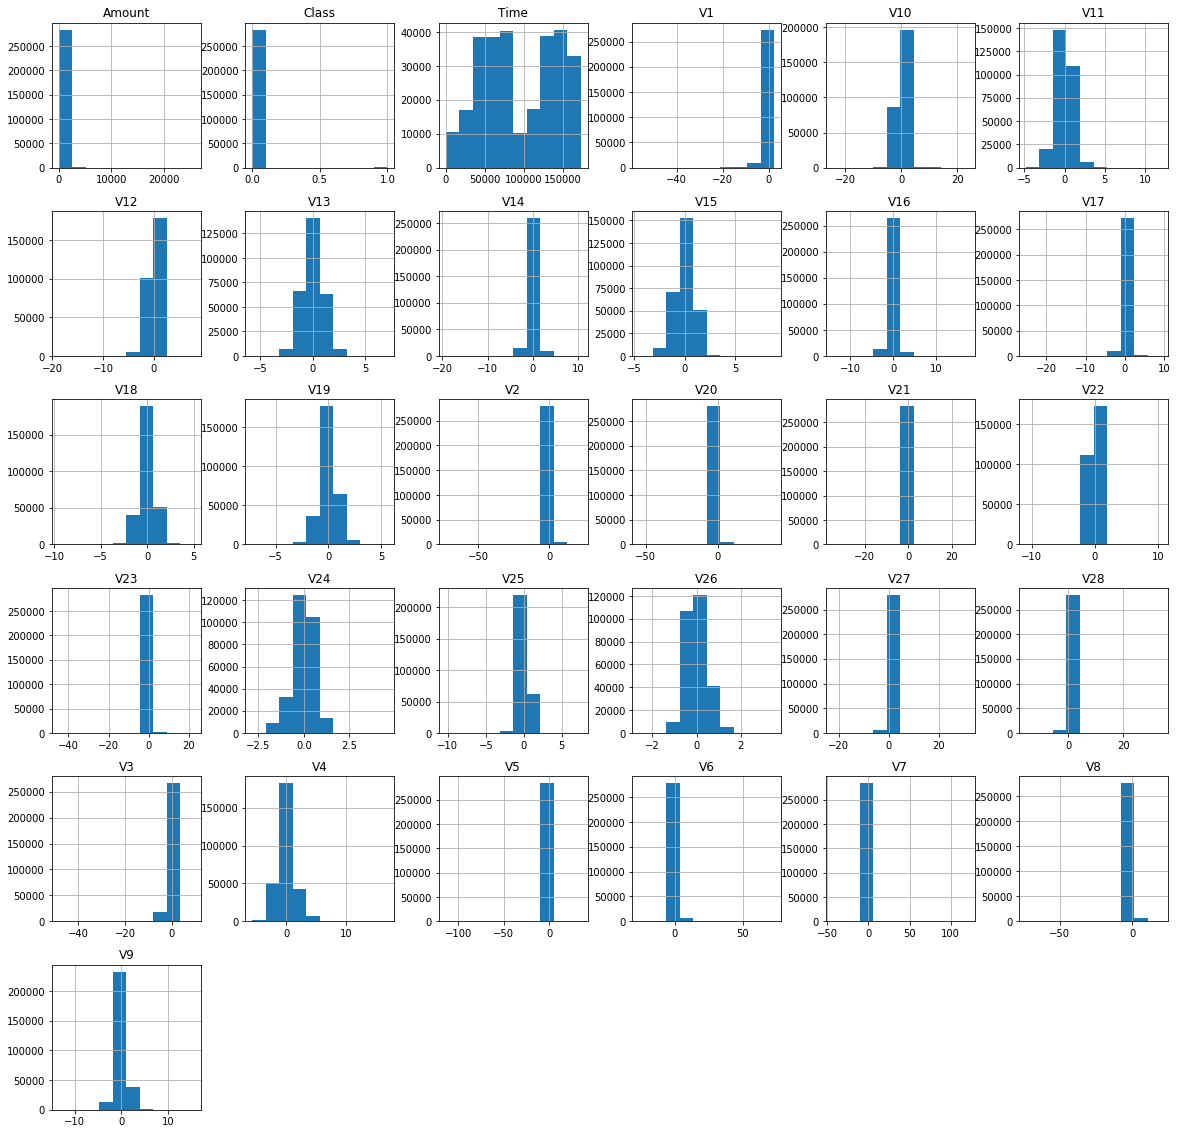

In [5]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

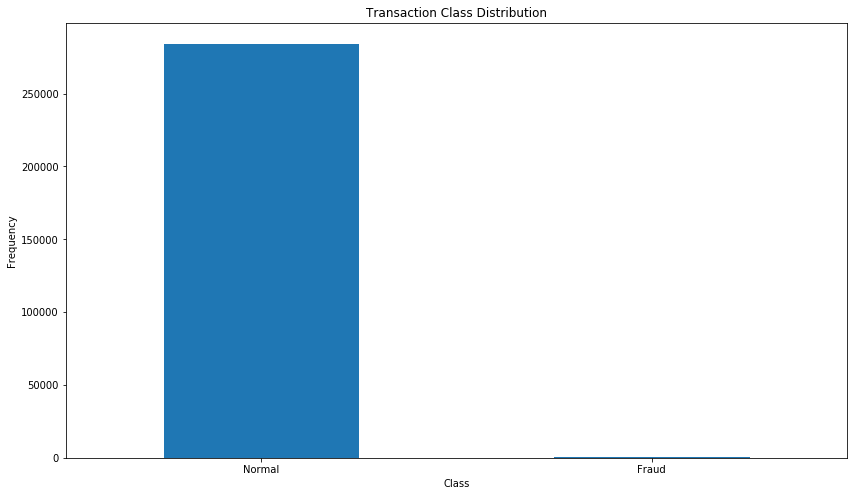

In [6]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")
plt.show()

In [7]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [8]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [9]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
data.shape

(284807, 31)

In [12]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [13]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [14]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


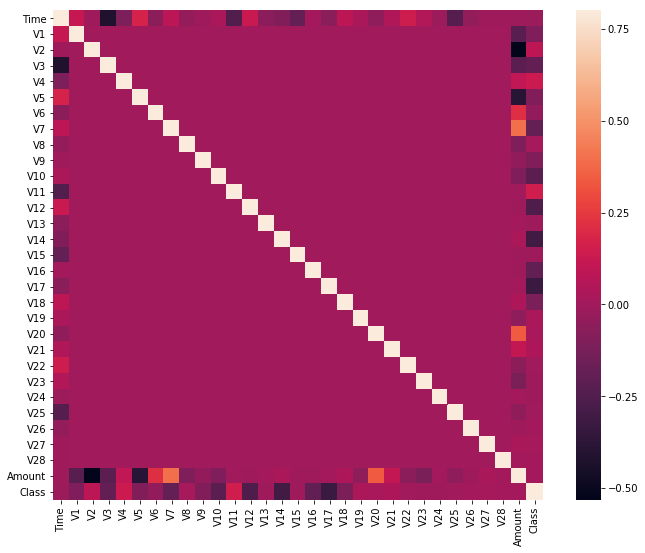

In [15]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [16]:
# Get all the columns from the dataFrame
columns = data1.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data1[columns]
Y = data1[target]

# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [17]:

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction)}

In [18]:
# Fit the model

n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

Isolation Forest: 75
0.997366665496
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.24      0.24      0.24        49

avg / total       1.00      1.00      1.00     28481

Local Outlier Factor: 97
0.996594220709
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.02      0.02      0.02        49

avg / total       1.00      1.00      1.00     28481

